In [99]:
import numpy as np
import bisect
from scipy.spatial import distance
from scipy.sparse import coo_matrix, csc_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
#from multiprocessing import Pool

In [100]:

def construct_X(M,alphas,Np=None):
    """ Calculates the weight matrix for a given tomogram size M x M, X-rays under angles alpha and sensor resolution Np
    
    Parameters:
    -----------
    Number of pixel of square tomogram: M (Int)
    List of angles under which CT is performed: alphas (List of Int)
    Resolution of CCD sensor (optional): Np (Int)
    
    
    If Np = None, Np is set as ceiling(sqrt(2)*M)
    
    Returns:
    Np * len(alphas) x M*M matrix with weights of the pixels
    """
    if Np == None: Np = np.ceil(np.sqrt(2)*M)
    a0 = -M/2 + 0.5
    b0 = -M/2 + 0.5
    C = np.mgrid[a0:M+a0,b0:M+b0]
  
    C = C.reshape(2,M*M) # array of (a,b) vectors that belong to the centers of the bins
    
    
    n = np.array([0,1]) # unrotated unit vector
    weights = np.array([])
 
    x_idx = np.zeros((2,1))
    #project tomogram pixel on sensor
    alphas = np.array(alphas)/360 * 2 * np.pi 
    def rot(a):
        return np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    p = np.dot(np.array([np.dot(rot(i),n)for i in alphas]),C).flatten() # vectorized for all alphas at the same time

    # calculate differences and use boolean slicing to get rid of pixels that do not count
    sensor = np.arange(-Np/2+0.5,Np/2+0.5,1) # sensor bin center coordinates
    
    
    #d = np.abs(distance.cdist(sensor.reshape(sensor.shape[0],1),p.reshape(p.shape[0],1))) # memor error for full array
    
    #d = np.concatenate(np.hsplit(d,len(alphas)),axis=0) # transform matrix from Np x len (alpha)* M*M to Np*len(alpha) x M*M     
    #idx = np.where(d<1) # select relevant elements, i.e. where distance of projected tomograph pixels to sensor pixels smaller 1
    for count,i in enumerate(alphas):
        p = np.dot(np.array(np.dot(rot(i),n)),C) # vectorized for all alphas at the same time
        d = np.abs(distance.cdist(sensor.reshape(sensor.shape[0],1),p.reshape(p.shape[0],1))) # memor error for full array
        idx = np.where(d<1) # select relevant elements, i.e. where distance of projected tomograph pixels to sensor pixels smaller 1
        weights = np.append(weights,1-d[idx])
        x_idx = np.append(x_idx,np.array([idx[0]+count*Np,idx[1]]),axis=1)
    
    X = coo_matrix((weights,x_idx[:,1:]),shape=(int(Np*len(alphas)),M*M),dtype=np.float32) # save relevant weigths in array. Triangular shape of resulting signal 

    #X = coo_matrix(((1-d[idx]),idx),shape=(int(Np*len(alphas)),M*M),dtype=np.float32) # save relevant weigths in array. Triangular shape of resulting signal 
                                                                                    # is achieved by 1 - d
    return X

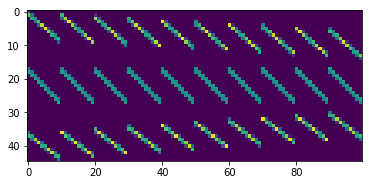

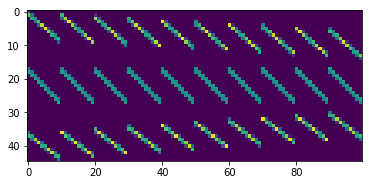

In [101]:
X = construct_X(10,[-33,1,42])
#X = construct_X(2,[0])
#X = construct_X(2,[0,90])
plt.imshow(X.toarray())
X_test = np.load('./hs_tomography/X_example.npy')
plt.show()
plt.imshow(X_test)
plt.show()


In [ ]:
alphas = np.load('./hs_tomography/alphas_77.npy')
X_77 = csc_matrix(construct_X(77,alphas,109))
y_77 = csc_matrix(np.load('./hs_tomography/y_77.npy'))
y_77 = np.load('./hs_tomography/y_77.npy')
print("%d non-zero elements. (%f percent)" % (X_77.count_nonzero(),100.0 * X_77.count_nonzero()/(X_77.shape[0]*X_77.shape[1])))
beta = lsqr(X_77,y_77,atol=10**-5,btol=10**-5)[0]
plt.imshow(beta.reshape(77,77))
plt.show()

13551667 non-zero elements. (0.723999 percent)


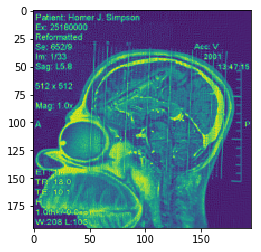

In [103]:
alphas = np.load('./hs_tomography/alphas_195.npy')
X_195 = csc_matrix(construct_X(195,alphas,275))
y_195 = csc_matrix(np.load('./hs_tomography/y_195.npy'))
y_195 = np.load('./hs_tomography/y_195.npy')
nonzero = X_195.count_nonzero()
print("%d non-zero elements. (%f percent)" % (nonzero,100.0 * nonzero/(X_195.shape[0]*X_195.shape[1])))
beta = lsqr(X_195,y_195,atol=10**-6,btol=10**-6)[0]
plt.imshow(beta.reshape(195,195))
plt.show()

In [80]:
%%timeit
construct_X(195,alphas,275)

KeyboardInterrupt: 

In [98]:
construct_X.evaluate

AttributeError: 'function' object has no attribute 'evaluate'